## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
from scipy.stats import spearmanr

from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torch.optim import lr_scheduler

import time
from tqdm import tqdm

from radam import RAdam
from text_data import TextDataset
from net import NeuralNet5, GELU
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from text_cleaning import clean_data
from word_embed import build_matrix_adv, get_word_lemma_dict
from sentence_embed import get_use_embedding_features, get_distill_bert_features
from create_features import get_dist_features, get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np
from inference import infer
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

Using TensorFlow backend.


## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv').fillna(' ')
train = pd.read_csv(f'{path}train.csv').fillna(' ')

In [3]:
train = clean_data(train, INPUTS)
test = clean_data(test,INPUTS)

In [4]:
init_seed()

In [5]:
%%time
use_feature_path = 'proc_data/use_embedding_features/'
embedding_train, embedding_test = get_use_embedding_features(train, test, INPUTS, use_feature_path)

CPU times: user 1.15 s, sys: 35.7 ms, total: 1.18 s
Wall time: 1.18 s


In [6]:
%%time
distill_bert_feature_path = 'proc_data/distill_bert_features/'
bert_features_train, bert_features_test = get_distill_bert_features(
    train, test, ['question_body', 'answer'], 64, distill_bert_feature_path)

CPU times: user 1.11 s, sys: 15.8 ms, total: 1.13 s
Wall time: 1.13 s


In [7]:
%%time
dist_features_train, dist_features_test  = get_dist_features(embedding_train, embedding_test)

CPU times: user 998 ms, sys: 21.5 ms, total: 1.02 s
Wall time: 103 ms


In [8]:
tokenizer = Tokenizer()
full_text = []
for inp in INPUTS: full_text += list(train[inp])
for inp in INPUTS: full_text += list(test[inp])
tokenizer.fit_on_texts(full_text)

In [9]:
%%time
lemma_dict, word_dict = get_word_lemma_dict(full_text, 'proc_data/')

CPU times: user 18 ms, sys: 12.2 ms, total: 30.2 ms
Wall time: 25.5 ms


In [10]:
# embed_size=300
# embedding_path = 'pretrained_models/crawl-300d-2M.pkl'
# embedding_path_spellcheck = 'pretrained_models/wiki-news-300d-1M.vec'

In [11]:
# %%time
# matrix_path = 'proc_data/embedding_matrix/'
# embedding_matrix, nb_words, unknown_words = build_matrix_adv(
#     embedding_path, embedding_path_spellcheck, word_dict, lemma_dict, 100000, embed_size, matrix_path)

In [12]:
# tk.word_index = {k: v for k, v in tk.word_index.items() if k in word_dict.keys()}
# train['host'] = train['host'].apply(lambda x: x.split('.')[-2])
# test['host'] = test['host'].apply(lambda x: x.split('.')[-2])
train_host, test_host, host_dict, host_dict_reverse = get_categorical_features(train, test, 'host')
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [13]:
# max_len = 512
# max_len_title = 32
# train_question_tokenized = pad_sequences(tokenizer.texts_to_sequences(train['question_body']), maxlen=max_len)
# train_answer_tokenized = pad_sequences(tokenizer.texts_to_sequences(train['answer']), maxlen=max_len)
# train_title_tokenized = pad_sequences(tokenizer.texts_to_sequences(train['question_title']),maxlen=max_len_title)

# test_question_tokenized = pad_sequences(tokenizer.texts_to_sequences(test['question_body']), maxlen=max_len)
# test_answer_tokenized = pad_sequences(tokenizer.texts_to_sequences(test['answer']), maxlen=max_len)
# test_title_tokenized = pad_sequences(tokenizer.texts_to_sequences(test['question_title']), maxlen=max_len_title)

In [14]:
cat_features_train = np.hstack([train_host.reshape(-1, 1), train_category.reshape(-1, 1)])
cat_features_test = np.hstack([test_host.reshape(-1, 1), test_category.reshape(-1, 1)])
merged = np.vstack([cat_features_train, cat_features_test])
ohe = OneHotEncoder()
ohe.fit(merged)

cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [15]:
x_train = np.hstack(list(embedding_train.values()) 
                    + [cat_features_train, dist_features_train]
                    + list(bert_features_train.values())).astype(np.float32)
x_test = np.hstack(list(embedding_test.values()) 
                   + [cat_features_test, dist_features_test]
                   + list(bert_features_test.values())).astype(np.float32)

In [16]:
y = train[TARGETS].values.astype(np.float32)

In [17]:
num_workers = 10
bs = 32
n_x = x_train.shape[1]

In [18]:
bs_test = 8
test_loader = DataLoader(
    TensorDataset(torch.Tensor(x_test), torch.Tensor(np.zeros((len(x_test), N_TARGETS), dtype=np.float32))),
    batch_size=bs_test, shuffle=False, num_workers=num_workers
)

In [19]:
class Net(nn.Module):
    def __init__(self, n_x, n_h=512):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(n_x, n_h),
            GELU(),#nn.ELU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(n_h, N_TARGETS)
        )
        
    def forward(self, x):
        return self.head(x)

## Training model

In [20]:
lr = 0.001
loss_fn = nn.BCEWithLogitsLoss()
device = torch.device('cuda')
n_epochs = 10
model_name = 'net5'
checkpoint_dir = 'checkpoints/'
early_stopping = None

Fold 1 started at Mon Dec  2 21:24:32 2019
Net(
  (head): Sequential(
    (0): Linear(in_features=3147, out_features=512, bias=True)
    (1): GELU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=30, bias=True)
  )
)


 49%|████▉     | 49/100 [00:00<00:00, 89.13it/s]


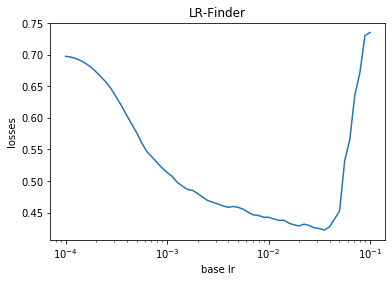

epoch 0: 	 Start training...



epoch 0/10 	 train : loss 0.4762 - spearmanr 0.081289
epoch 0: 	 Start validation...



epoch 0/10 	 valid : loss 0.40367 - spearmanr 0.2593
best model: epoch 0 - 0.2593
epoch 1: 	 Start training...



epoch 1/10 	 train : loss 0.39432 - spearmanr 0.26799
epoch 1: 	 Start validation...



epoch 1/10 	 valid : loss 0.3875 - spearmanr 0.34213
best model: epoch 1 - 0.34213
epoch 2: 	 Start training...



epoch 2/10 	 train : loss 0.3805 - spearmanr 0.33679
epoch 2: 	 Start validation...



epoch 2/10 	 valid : loss 0.38225 - spearmanr 0.36582
best model: epoch 2 - 0.36582
epoch 3: 	 Start training...



epoch 3/10 	 train : loss 0.37169 - spearmanr 0.37264
epoch 3: 	 Start validation...



epoch 3/10 	 valid : loss 0.38201 - spearmanr 0.37579
best model: epoch 3 - 0.37579
epoch 4: 	 Start training...



epoch 4/10 	 train : loss 0.36446 - spearmanr 0.40459
epoch 4: 	 Start validation...



epoch 4/10 	 valid : loss 0.37715 - spearmanr 0.3804
best model: epoch 4 - 0.3804
epoch 5: 	 Start training...



epoch 5/10 	 train : loss 0.35815 - spearmanr 0.42921
epoch 5: 	 Start validation...



epoch 5/10 	 valid : loss 0.37495 - spearmanr 0.38524
best model: epoch 5 - 0.38524
epoch 6: 	 Start training...



epoch 6/10 	 train : loss 0.35351 - spearmanr 0.44725
epoch 6: 	 Start validation...



epoch 6/10 	 valid : loss 0.37428 - spearmanr 0.3858
best model: epoch 6 - 0.3858
epoch 7: 	 Start training...



epoch 7/10 	 train : loss 0.34888 - spearmanr 0.46566
epoch 7: 	 Start validation...



epoch 7/10 	 valid : loss 0.37408 - spearmanr 0.38693
best model: epoch 7 - 0.38693
epoch 8: 	 Start training...



epoch 8/10 	 train : loss 0.34616 - spearmanr 0.47628
epoch 8: 	 Start validation...



epoch 8/10 	 valid : loss 0.37291 - spearmanr 0.3874
best model: epoch 8 - 0.3874
epoch 9: 	 Start training...



epoch 9/10 	 train : loss 0.34445 - spearmanr 0.4851
epoch 9: 	 Start validation...



epoch 9/10 	 valid : loss 0.37262 - spearmanr 0.38746
best model: epoch 9 - 0.38746
TRAINING END: Best score achieved on epoch 9 - 0.38746
Starting inference for model: checkpoints/net5_fold_1_best.pth



Starting inference for model: checkpoints/net5_fold_1_best.pth



Fold 2 started at Mon Dec  2 21:24:55 2019
epoch 0: 	 Start training...



epoch 0/10 	 train : loss 0.47082 - spearmanr 0.088973
epoch 0: 	 Start validation...



epoch 0/10 	 valid : loss 0.40183 - spearmanr 0.25187
best model: epoch 0 - 0.25187
epoch 1: 	 Start training...



epoch 1/10 	 train : loss 0.39592 - spearmanr 0.26609
epoch 1: 	 Start validation...



epoch 1/10 	 valid : loss 0.38502 - spearmanr 0.33703
best model: epoch 1 - 0.33703
epoch 2: 	 Start training...



epoch 2/10 	 train : loss 0.38207 - spearmanr 0.33311
epoch 2: 	 Start validation...



epoch 2/10 	 valid : loss 0.37862 - spearmanr 0.36488
best model: epoch 2 - 0.36488
epoch 3: 	 Start training...



epoch 3/10 	 train : loss 0.37258 - spearmanr 0.37451
epoch 3: 	 Start validation...



epoch 3/10 	 valid : loss 0.37802 - spearmanr 0.37535
best model: epoch 3 - 0.37535
epoch 4: 	 Start training...



epoch 4/10 	 train : loss 0.36511 - spearmanr 0.40577
epoch 4: 	 Start validation...



epoch 4/10 	 valid : loss 0.37152 - spearmanr 0.38448
best model: epoch 4 - 0.38448
epoch 5: 	 Start training...



epoch 5/10 	 train : loss 0.35927 - spearmanr 0.42567
epoch 5: 	 Start validation...



epoch 5/10 	 valid : loss 0.36904 - spearmanr 0.38978
best model: epoch 5 - 0.38978
epoch 6: 	 Start training...



epoch 6/10 	 train : loss 0.3545 - spearmanr 0.44674
epoch 6: 	 Start validation...



epoch 6/10 	 valid : loss 0.36908 - spearmanr 0.38958
model not improved for 1 epochs
epoch 7: 	 Start training...



epoch 7/10 	 train : loss 0.34968 - spearmanr 0.46537
epoch 7: 	 Start validation...



epoch 7/10 	 valid : loss 0.36802 - spearmanr 0.39243
best model: epoch 7 - 0.39243
epoch 8: 	 Start training...



epoch 8/10 	 train : loss 0.34636 - spearmanr 0.48058
epoch 8: 	 Start validation...



epoch 8/10 	 valid : loss 0.36751 - spearmanr 0.39211
model not improved for 1 epochs
epoch 9: 	 Start training...



epoch 9/10 	 train : loss 0.34481 - spearmanr 0.48538
epoch 9: 	 Start validation...



epoch 9/10 	 valid : loss 0.36742 - spearmanr 0.39229
model not improved for 2 epochs
TRAINING END: Best score achieved on epoch 7 - 0.39243
Starting inference for model: checkpoints/net5_fold_2_best.pth



Starting inference for model: checkpoints/net5_fold_2_best.pth



Fold 3 started at Mon Dec  2 21:25:18 2019
epoch 0: 	 Start training...



epoch 0/10 	 train : loss 0.47298 - spearmanr 0.086422
epoch 0: 	 Start validation...



epoch 0/10 	 valid : loss 0.39942 - spearmanr 0.26932
best model: epoch 0 - 0.26932
epoch 1: 	 Start training...



epoch 1/10 	 train : loss 0.39546 - spearmanr 0.26619
epoch 1: 	 Start validation...



epoch 1/10 	 valid : loss 0.38547 - spearmanr 0.34471
best model: epoch 1 - 0.34471
epoch 2: 	 Start training...



epoch 2/10 	 train : loss 0.38189 - spearmanr 0.33389
epoch 2: 	 Start validation...



epoch 2/10 	 valid : loss 0.37737 - spearmanr 0.37117
best model: epoch 2 - 0.37117
epoch 3: 	 Start training...



epoch 3/10 	 train : loss 0.37294 - spearmanr 0.37231
epoch 3: 	 Start validation...



epoch 3/10 	 valid : loss 0.37277 - spearmanr 0.3864
best model: epoch 3 - 0.3864
epoch 4: 	 Start training...



epoch 4/10 	 train : loss 0.36562 - spearmanr 0.40472
epoch 4: 	 Start validation...



epoch 4/10 	 valid : loss 0.3709 - spearmanr 0.39134
best model: epoch 4 - 0.39134
epoch 5: 	 Start training...



epoch 5/10 	 train : loss 0.3599 - spearmanr 0.42438
epoch 5: 	 Start validation...



epoch 5/10 	 valid : loss 0.37035 - spearmanr 0.39382
best model: epoch 5 - 0.39382
epoch 6: 	 Start training...



epoch 6/10 	 train : loss 0.3544 - spearmanr 0.44672
epoch 6: 	 Start validation...



epoch 6/10 	 valid : loss 0.36748 - spearmanr 0.39697
best model: epoch 6 - 0.39697
epoch 7: 	 Start training...



epoch 7/10 	 train : loss 0.35001 - spearmanr 0.46462
epoch 7: 	 Start validation...



epoch 7/10 	 valid : loss 0.36771 - spearmanr 0.39754
best model: epoch 7 - 0.39754
epoch 8: 	 Start training...



epoch 8/10 	 train : loss 0.34737 - spearmanr 0.47451
epoch 8: 	 Start validation...



epoch 8/10 	 valid : loss 0.36721 - spearmanr 0.3984
best model: epoch 8 - 0.3984
epoch 9: 	 Start training...



epoch 9/10 	 train : loss 0.34572 - spearmanr 0.48236
epoch 9: 	 Start validation...



epoch 9/10 	 valid : loss 0.36717 - spearmanr 0.39903
best model: epoch 9 - 0.39903
TRAINING END: Best score achieved on epoch 9 - 0.39903
Starting inference for model: checkpoints/net5_fold_3_best.pth



Starting inference for model: checkpoints/net5_fold_3_best.pth



Fold 4 started at Mon Dec  2 21:25:40 2019
epoch 0: 	 Start training...



epoch 0/10 	 train : loss 0.47315 - spearmanr 0.081152
epoch 0: 	 Start validation...



epoch 0/10 	 valid : loss 0.40355 - spearmanr 0.27043
best model: epoch 0 - 0.27043
epoch 1: 	 Start training...



epoch 1/10 	 train : loss 0.39572 - spearmanr 0.26829
epoch 1: 	 Start validation...



epoch 1/10 	 valid : loss 0.38523 - spearmanr 0.34207
best model: epoch 1 - 0.34207
epoch 2: 	 Start training...



epoch 2/10 	 train : loss 0.38188 - spearmanr 0.33147
epoch 2: 	 Start validation...



epoch 2/10 	 valid : loss 0.37643 - spearmanr 0.37142
best model: epoch 2 - 0.37142
epoch 3: 	 Start training...



epoch 3/10 	 train : loss 0.37309 - spearmanr 0.3749
epoch 3: 	 Start validation...



epoch 3/10 	 valid : loss 0.37336 - spearmanr 0.38044
best model: epoch 3 - 0.38044
epoch 4: 	 Start training...



epoch 4/10 	 train : loss 0.36632 - spearmanr 0.39983
epoch 4: 	 Start validation...



epoch 4/10 	 valid : loss 0.36921 - spearmanr 0.38844
best model: epoch 4 - 0.38844
epoch 5: 	 Start training...



epoch 5/10 	 train : loss 0.36103 - spearmanr 0.42269
epoch 5: 	 Start validation...



epoch 5/10 	 valid : loss 0.3682 - spearmanr 0.3944
best model: epoch 5 - 0.3944
epoch 6: 	 Start training...



epoch 6/10 	 train : loss 0.35544 - spearmanr 0.44359
epoch 6: 	 Start validation...



epoch 6/10 	 valid : loss 0.36774 - spearmanr 0.39483
best model: epoch 6 - 0.39483
epoch 7: 	 Start training...



epoch 7/10 	 train : loss 0.35115 - spearmanr 0.46266
epoch 7: 	 Start validation...



epoch 7/10 	 valid : loss 0.36687 - spearmanr 0.39839
best model: epoch 7 - 0.39839
epoch 8: 	 Start training...



epoch 8/10 	 train : loss 0.34823 - spearmanr 0.47285
epoch 8: 	 Start validation...



epoch 8/10 	 valid : loss 0.36595 - spearmanr 0.39811
model not improved for 1 epochs
epoch 9: 	 Start training...



epoch 9/10 	 train : loss 0.34624 - spearmanr 0.48281
epoch 9: 	 Start validation...



epoch 9/10 	 valid : loss 0.36554 - spearmanr 0.3984
best model: epoch 9 - 0.3984
TRAINING END: Best score achieved on epoch 9 - 0.39840
Starting inference for model: checkpoints/net5_fold_4_best.pth



Starting inference for model: checkpoints/net5_fold_4_best.pth



Fold 5 started at Mon Dec  2 21:26:03 2019
epoch 0: 	 Start training...



epoch 0/10 	 train : loss 0.47259 - spearmanr 0.094086
epoch 0: 	 Start validation...



epoch 0/10 	 valid : loss 0.40345 - spearmanr 0.26513
best model: epoch 0 - 0.26513
epoch 1: 	 Start training...


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)



epoch 1/10 	 train : loss 0.39479 - spearmanr 0.26644
epoch 1: 	 Start validation...



epoch 1/10 	 valid : loss 0.38808 - spearmanr 0.34109
best model: epoch 1 - 0.34109
epoch 2: 	 Start training...



epoch 2/10 	 train : loss 0.38106 - spearmanr 0.33668
epoch 2: 	 Start validation...



epoch 2/10 	 valid : loss 0.37928 - spearmanr 0.36322
best model: epoch 2 - 0.36322
epoch 3: 	 Start training...



epoch 3/10 	 train : loss 0.37175 - spearmanr 0.37679
epoch 3: 	 Start validation...



epoch 3/10 	 valid : loss 0.37821 - spearmanr 0.38071
best model: epoch 3 - 0.38071
epoch 4: 	 Start training...



epoch 4/10 	 train : loss 0.36479 - spearmanr 0.40627
epoch 4: 	 Start validation...



epoch 4/10 	 valid : loss 0.37423 - spearmanr 0.38823
best model: epoch 4 - 0.38823
epoch 5: 	 Start training...



epoch 5/10 	 train : loss 0.35932 - spearmanr 0.42538
epoch 5: 	 Start validation...



epoch 5/10 	 valid : loss 0.37235 - spearmanr 0.38906
best model: epoch 5 - 0.38906
epoch 6: 	 Start training...



epoch 6/10 	 train : loss 0.35437 - spearmanr 0.44655
epoch 6: 	 Start validation...



epoch 6/10 	 valid : loss 0.37218 - spearmanr 0.39042
best model: epoch 6 - 0.39042
epoch 7: 	 Start training...



epoch 7/10 	 train : loss 0.34951 - spearmanr 0.46652
epoch 7: 	 Start validation...



epoch 7/10 	 valid : loss 0.37036 - spearmanr 0.39398
best model: epoch 7 - 0.39398
epoch 8: 	 Start training...



epoch 8/10 	 train : loss 0.34659 - spearmanr 0.47838
epoch 8: 	 Start validation...



epoch 8/10 	 valid : loss 0.36976 - spearmanr 0.39364
model not improved for 1 epochs
epoch 9: 	 Start training...



epoch 9/10 	 train : loss 0.34476 - spearmanr 0.48411
epoch 9: 	 Start validation...



epoch 9/10 	 valid : loss 0.36953 - spearmanr 0.39345
model not improved for 2 epochs
TRAINING END: Best score achieved on epoch 7 - 0.39398
Starting inference for model: checkpoints/net5_fold_5_best.pth



Starting inference for model: checkpoints/net5_fold_5_best.pth



OOF score: 0.3926235633725105


In [21]:
folds = KFold(n_splits=5, random_state=42)
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds.split(train)):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(TensorDataset(torch.Tensor(x_train[train_index]), 
                                            torch.Tensor(y[train_index])),
                              batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True)
    valid_loader = DataLoader(TensorDataset(torch.Tensor(x_train[valid_index]), 
                                            torch.Tensor(y[valid_index])),
                              batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True)
        
    model = Net(n_x, 512)
    model.to(device)
    
    if fold_id == 0:
        print(model)
        if 1:
            optimizer = optim.Adam(model.parameters(), lr)
            lr_finder = LRFinder(n_iter=100, start_lr=1e-4, end_lr=10, device=device)
            lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
            plt.show()
    
    optimizer = optim.Adam(model.parameters(), lr)
    #scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None, 
        early_stopping=early_stopping, 
        batch_step_scheduler=True
    )
    
    learner.train()
    
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / folds.n_splits
    
print(f'OOF score: {spearmanr_np(oofs, y)}')
#0.3936

In [22]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [23]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.910118,0.592023,0.056142,0.633289,0.791086,0.840520,0.638915,0.569078,0.460521,0.004678,0.446449,0.661436,0.005244,0.073651,0.014494,0.015951,0.136673,0.120720,0.739955,0.001304,0.846217,0.913549,0.594975,0.951576,0.957758,0.814960,0.048823,0.063419,0.884967,0.924022
1,46,0.855308,0.537921,0.004354,0.729413,0.804123,0.916769,0.561429,0.447747,0.060752,0.005945,0.412566,0.125019,0.002725,0.000440,0.000579,0.007843,0.925942,0.160062,0.098560,0.000346,0.607744,0.930530,0.629769,0.960757,0.972883,0.847287,0.934099,0.098683,0.093770,0.885035
2,70,0.887930,0.618123,0.011459,0.696932,0.898746,0.957876,0.574490,0.455992,0.242827,0.004689,0.256161,0.577748,0.010888,0.018460,0.005155,0.006160,0.352647,0.085033,0.690580,0.001296,0.845728,0.921306,0.603048,0.964645,0.966828,0.833049,0.130618,0.068846,0.842006,0.916958
3,132,0.870935,0.315488,0.003296,0.711344,0.816177,0.938617,0.551519,0.457465,0.443221,0.003638,0.475022,0.337748,0.004938,0.004987,0.001554,0.004814,0.746591,0.194650,0.699792,0.000318,0.657707,0.963502,0.717189,0.980206,0.987918,0.914663,0.806169,0.166724,0.755866,0.910690
4,200,0.966341,0.597470,0.016462,0.907727,0.851881,0.941517,0.657989,0.640082,0.346028,0.003998,0.333323,0.760539,0.005761,0.012549,0.002704,0.042161,0.168263,0.202480,0.471240,0.001544,0.843281,0.947161,0.687399,0.978112,0.974988,0.872334,0.223784,0.206118,0.660638,0.904767
